# Rasdaman Data Access Examples

*Rob Knapen, Wageningen Environmental Research*
<br>

This notebook covers some first examples with using Rasdaman coverage services (WCS and WCPS).

The Open Geospatial Consortium has defined coverages by the Coverage Implementation Schema (CIS). Each coverage mainly consists of the following:
  - An Envelope: which gives a rough, simplified overview of the data's location in space and time,
  - A domain set: which provides information about the spatial (including CRS) and temporal dimensions of the data,
  - A range set: the "payload", i.e. the values, or records of values,
  - A range type: the semantics of the range values, including data types, null values, accuracy, etc.,
  - Metadata: a container for any type of (descriptive) data.

In [2]:
# this notebook uses dotenv to retrieve secrets from environment variables
# get it with: pip install python-dotenv

%load_ext dotenv
%dotenv

In [3]:
import os

# read the secret information ...
#   Create a .env file in the notebooks folder first that has entries like:
#
#   RASDAMAN_SERVICE_ENDPOINT=<url>
#   RASDAMAN_CRED_USERNAME=<rasdaman_endpoint_username>
#   RASDAMAN_CRED_PASSWORD=<rasdaman_endpoint_password>
#   etc.

rasdaman_username = os.getenv("RASDAMAN_CRED_USERNAME")
rasdaman_password = os.getenv("RASDAMAN_CRED_PASSWORD")
rasdaman_endpoint = os.getenv("RASDAMAN_SERVICE_ENDPOINT")

# url to the rasdaman petascope geo service handling WCS requests
base_wcs_url = rasdaman_endpoint + "?service=WCS&version=2.1.0"

print(base_wcs_url)

http://fairicube.rasdaman.com:8080/rasdaman/ows?service=WCS&version=2.1.0


## Using Web Coverage Service (WCS)
The Web Coverage Service is one of the geo service standards by the Open Geospatial Consortium (OGC) that is supported by rasdaman. WCS delivers n-dimensional data, suitable for further processing and analysis. The service is a modular suite of functionality, with WCS Core providing the main downloading of coverages and parts thereof (via subsetting directives), as well as delivery in various output formats. A set of WCS Extensions can add further functionality.

WCS Core supports the following requests: GetCapabilities, DescribeCoverage, and GetCoverage.

### WCS - GetCapabilities
This request returns a list of available coverages, and an overall service description.

In [4]:
import requests
import json
import xmltodict

# retrieve a description of the WCS using the GetCapabilities request
response = requests.get(base_wcs_url + "&request=GetCapabilities", auth=(rasdaman_username, rasdaman_password))
wcs_capabilities = xmltodict.parse(response.content)
print(json.dumps(wcs_capabilities, indent=2))

{
  "wcs:Capabilities": {
    "@version": "2.1.0",
    "@xsi:schemaLocation": "http://www.opengis.net/wcs/2.1 http://schemas.opengis.net/wcs/2.1/wcsGetCapabilities.xsd",
    "@xmlns:wcs": "http://www.opengis.net/wcs/2.1",
    "@xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
    "@xmlns:gml": "http://www.opengis.net/gml/3.2",
    "@xmlns:swe": "http://www.opengis.net/swe/2.0",
    "@xmlns:ows": "http://www.opengis.net/ows/2.0",
    "@xmlns:xlink": "http://www.w3.org/1999/xlink",
    "@xmlns:rasdaman": "http://www.rasdaman.org",
    "@xmlns:int": "http://www.opengis.net/wcs/interpolation/1.0",
    "@xmlns:crs": "http://www.opengis.net/wcs/service-extension/crs/1.0",
    "@xmlns:inspire_dls": "http://inspire.ec.europa.eu/schemas/inspire_dls/1.0",
    "@xmlns:inspire_common": "http://inspire.ec.europa.eu/schemas/common/1.0",
    "ows:ServiceIdentification": {
      "ows:Title": "rasdaman",
      "ows:Abstract": "rasdaman server - free download from www.rasdaman.org",
      "ows:S

In [5]:
# list the WCS contents - all available coverages
wcs_coverage_summary = wcs_capabilities['wcs:Capabilities']['wcs:Contents']['wcs:CoverageSummary']
coverage_ids = [summary['wcs:CoverageId'] for summary in wcs_coverage_summary]
coverage_ids

['AverageChlorophyll',
 'corine_land_cover',
 'dominant_leaf_type',
 'european_settlement_map',
 'grassland_change',
 'grassland_status',
 'grassland_status_demo',
 'high_resolution_layer_forest_type',
 'imperviousness',
 'maxes_sentinel2_2018_flevopolder_10m_7x4bands',
 'sentinel2_2018_flevopolder_10m_7x4bands',
 'tree_cover_density',
 'water_and_wetness']

### WCS - DescribeCoverage

In [6]:
# retrieve a description of a coverage using the DescribeCoverage request
# coverage_id = "corine_land_cover"
coverage_id = "grassland_status_demo"

response = requests.get(base_wcs_url + "&request=DescribeCoverage&coverageId=" + coverage_id,
                        auth=(rasdaman_username, rasdaman_password)
                        )
wcs_coverage_description = xmltodict.parse(response.content)
print(json.dumps(wcs_coverage_description, indent=2))

{
  "wcs:CoverageDescriptions": {
    "@xsi:schemaLocation": "http://www.opengis.net/gml/3.3/rgrid http://schemas.opengis.net/gml/3.3/referenceableGrid.xsd",
    "@xmlns:wcs": "http://www.opengis.net/wcs/2.0",
    "@xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
    "@xmlns:gml": "http://www.opengis.net/gml/3.2",
    "@xmlns:swe": "http://www.opengis.net/swe/2.0",
    "@xmlns:ows": "http://www.opengis.net/ows/2.0",
    "@xmlns:xlink": "http://www.w3.org/1999/xlink",
    "@xmlns:rasdaman": "http://www.rasdaman.org",
    "@xmlns:gmlrgrid": "http://www.opengis.net/gml/3.3/rgrid",
    "@xmlns:gmlcov": "http://www.opengis.net/gmlcov/1.0",
    "wcs:CoverageDescription": {
      "@gml:id": "grassland_status_demo",
      "gml:boundedBy": {
        "gml:Envelope": {
          "@srsName": "http://localhost:8080/rasdaman/def/crs-compound?1=http://localhost:8080/rasdaman/def/crs/OGC/0/Index1D?axis-label=\"time\"&2=http://localhost:8080/rasdaman/def/crs/EPSG/0/3035",
          "@axisLabel

### WCS - GetCoverage

In [11]:
cov_id = "&COVERAGEID=" + coverage_id

# encode_format = "&FORMAT=application/netcdf" # netcdf is the recommended format for xarray data

# Corine
# lower corner: 900_000, 900_000
# upper corner: 5_500_000, 7_400_000

# Grassland
# "gml:lowerCorner": "2018 1800000 5000000",
# "gml:upperCorner": "2018 2300000 5300000"


# Area in NL: 3_274_257, 3_951_147 - 3_214_817, 3_953_947
subset = '&subset=time("2018") &subset=Y(2000000, 2100000) &subset=X(5100000, 5200000)'

encode_format = "&format=image/tiff"

request_url = base_wcs_url + "&request=GetCoverage" + cov_id + encode_format + subset
print(request_url)

response = requests.get(
    request_url,
    auth=(rasdaman_username, rasdaman_password),
    verify=False)

wcs_coverage_data = response.content

# show content if there was an error
if not response.ok:
    dict = xmltodict.parse(wcs_coverage_data)
    print(json.dumps(dict, indent=2))

http://fairicube.rasdaman.com:8080/rasdaman/ows?service=WCS&version=2.1.0&request=GetCoverage&COVERAGEID=grassland_status_demo&format=image/tiff&subset=time("2018") &subset=Y(2000000, 2100000) &subset=X(5100000, 5200000)


In [12]:
#wcs_coverage_data

/vsimem/51bcc36f-55dc-4a3d-8fc8-44bbb3ff613b/51bcc36f-55dc-4a3d-8fc8-44bbb3ff613b.tif 1 10000 10000
BoundingBox(left=5100000.0, bottom=2000000.0, right=5200000.0, top=2100000.0)


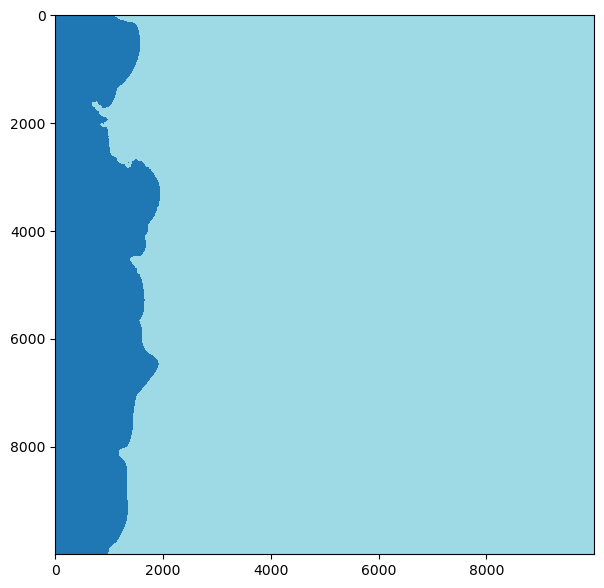

In [21]:
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
from rasterio import plot
from rasterio.plot import show_hist

with MemoryFile(wcs_coverage_data) as memfile:
    with memfile.open() as ds:
        print(ds.name, ds.count, ds.width, ds.height)
        print(ds.bounds)
        ds_array = ds.read(1)
        # show_hist(ds_array, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled')
        fig, ax = plt.subplots(1, figsize=(7, 7))
        plot.show(ds_array, cmap='tab20_r', interpolation='none', ax=ax)

## Using Web Coverage Processing Service (WCPS)

In [26]:
query = '''
for $c in (grassland_status_demo)
return
  encode(
    $c[ time(2018), X(5100000:5200000), Y(2000000:2100000) ],
    "image/tiff"
  )
'''

response = requests.get(
    base_wcs_url + "&request=ProcessCoverage&query=" + query,
    auth=(rasdaman_username, rasdaman_password),
    verify=False)

wcps_coverage_data = response.content

# show content if there was an error
if not response.ok:
    dict = xmltodict.parse(wcps_coverage_data)
    print(json.dumps(dict, indent=2))

/vsimem/386d2bdd-207f-467b-b35a-15ddda89c350/386d2bdd-207f-467b-b35a-15ddda89c350.tif 1 10000 10000
BoundingBox(left=5100000.0, bottom=2000000.0, right=5200000.0, top=2100000.0)


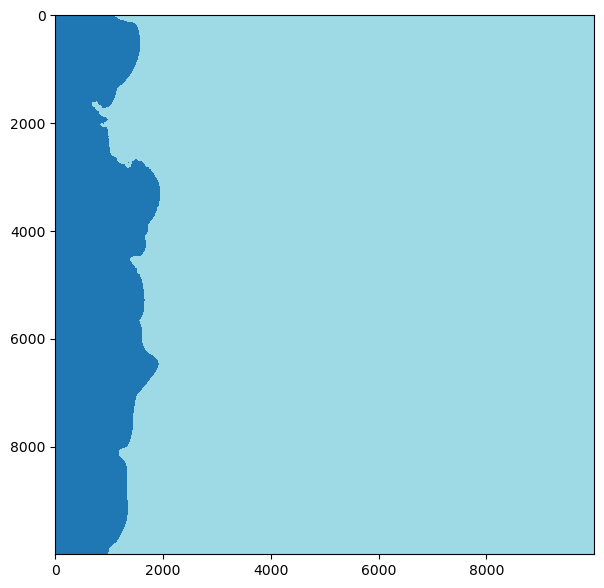

In [27]:
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
from rasterio import plot

with MemoryFile(wcps_coverage_data) as memfile:
    with memfile.open() as ds:
        print(ds.name, ds.count, ds.width, ds.height)
        print(ds.bounds)
        ds_array = ds.read(1)
        fig, ax = plt.subplots(1, figsize=(7, 7))
        plot.show(ds_array, cmap='tab20_r', interpolation='none', ax=ax)